In [1]:
from PIL import Image

import numpy as np
import mlx.core as mx
import mlx.nn as nn
import matplotlib.pyplot as plt

from alpineml import Network
from alpineml.Checkpoint import Checkpoint
from alpineml.layer.reshape import Flatten
from alpineml.layer.shim import MLX
from alpineml.optim import SGD
from alpineml.function.activation import leaky_relu, softmax
from alpineml.function.loss import CrossEntropyLoss, cross_entropy_loss
from alpineml.layer.core import Linear, Activation
from dataset import get_cifar10


In [2]:
# load model from checkpoint
network = Network(input_shape=(32, 32, 3))

# conv block 1
network.add_layer(MLX(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# conv block 2
network.add_layer(MLX(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3)))
network.add_layer(Activation(leaky_relu))
network.add_layer(MLX(nn.MaxPool2d(2)))
# feed forward
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Activation(leaky_relu))
network.add_layer(Linear(10))

network.load(Checkpoint.read("checkpoints/simple_conv.pb"))

In [395]:
def normalize(x):
    min_x = mx.min(x)
    x -= min_x

    max_x = mx.max(x)
    x /= max_x

    return x

def viz_input(x):
    x = 255 * np.array(x[0])
    img_x = Image.fromarray(x.astype('uint8'))
    plt.imshow(img_x)

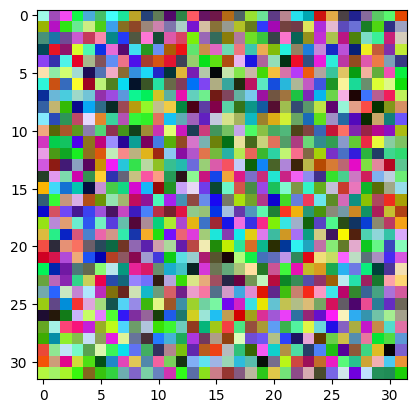

In [396]:
# create some noise
noise = mx.random.uniform(0, 1, (1, 32, 32, 3))
viz_input(noise)

In [5]:
# prepare to optimize the input image (noise)
network.freeze()
optimizer = SGD(eta=0.05, momentum=0.9, weight_decay=0.0005)
optimizer.bind_network(network)
optimizer.bind_loss_fn(cross_entropy_loss)

In [6]:
# Cifar-10 labels
#   0 -> Airplane
#   1 -> Automobile
#   2 -> Bird
#   3 -> Cat
#   4 -> Deer
#   5 -> Dog
#   6 -> Frog
#   7 -> Horse
#   8 -> Ship
#   9 -> Truck

[[1.91439452e-04 1.12152929e-06 9.99662280e-01 1.56167562e-06
  1.09963516e-07 1.31277466e-06 9.82390629e-05 1.35185992e-05
  2.77873831e-08 3.05425965e-05]]


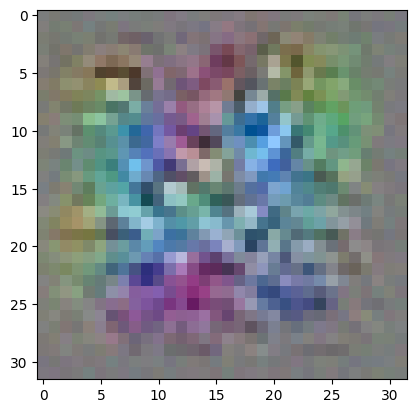

In [397]:
# Generate from noise
x = mx.random.uniform(0, 0.0001, (1, 32, 32, 3))

y = np.zeros((1, 10))  # one-hot encoded label
y[0][2] = 1

for i in range(10000):
    grad = optimizer.step(x, y)
    x -= 0.001 * grad
    x = normalize(x)

viz_input(x)
print(np.array(softmax(network.forward(x))))

In [8]:
# load data
train, test = get_cifar10()
train, test = list(train), list(test)

[[1.2218456e-14 4.4597561e-13 1.0736289e-06 1.5595332e-07 3.0886764e-09
  9.3163983e-11 9.9999881e-01 9.9097000e-13 2.9039455e-13 3.2024938e-11]]


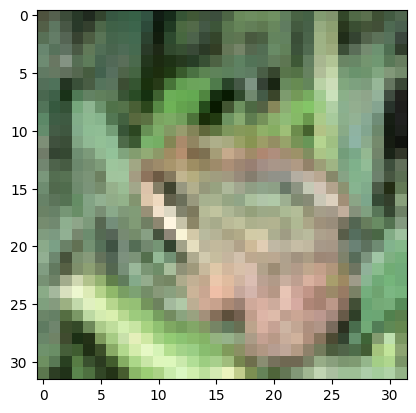

In [9]:
# Enhance existing image
x = test[4]['image']
x = mx.array(x.reshape((1, *x.shape)))
y = test[4]['label']
y = mx.array(y.reshape((1, *y.shape)))

for i in range(1000):
    grad = optimizer.step(x, y)
    x -= 0.1 * grad
    x = normalize(x)

viz_input(x)
print(np.array(softmax(network.forward(x))))

[[1.1385675e-14 1.7828133e-06 2.2792367e-20 2.8625543e-22 5.7152270e-18
  3.7494024e-22 3.7315949e-11 1.8813092e-22 2.5866236e-12 9.9999821e-01]]


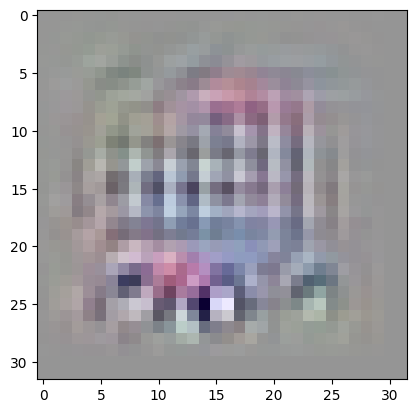

In [495]:
# Better visualization from noise
# x = mx.random.uniform(0, 1, (1, 32, 32, 3))
x = mx.random.normal((1, 32, 32, 3))

y = np.zeros((1, 10))  # one-hot encoded label
y[0][9] = 1

for i in range(500):
    grad = optimizer.step(x, y)
    x -= 2.5 * grad + 0.2 * x

# x = 2.5 * x + 0.5
x = normalize(x)
viz_input(x)
print(np.array(softmax(network.forward(x))))